<a href="https://colab.research.google.com/github/clint-bg/tools/blob/main/FallingSphereKinematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Falling Sphere Kinematics

In [1]:
#import needed packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate
from scipy.optimize import fsolve

In [2]:
#constants, all units are SI
gravity = 9.81 #m/s2
inch2m = 0.0254

## Code to estimate the velocity and position of a falling sphere as a function of time 

Needed variables: <br>
- sphere radius (m)
- sphere density (kg/m3)
- fluid density (kg/m3)
- fluid viscosity (Pa-s)

### First define the net force on the sphere: buoyancy, gravity, and drag

Governing equations

$F_{drag} = -1/2\cdot \rho_{fluid}\cdot v^2 \cdot C_{D}\cdot A$ <br>
$F_{buoyancy} = -\rho_{fluid}\cdot g \cdot V$ <Br>
$F_{gravity} = m\cdot g$

where A is the cross sectional area, $C_D$ is the drag coefficient, $v$ is velocity, $\rho$ is density, V is volume, and m is mass.

In [3]:
#Define the Reynolds number from the variables
def Re(v,rad,rho_fluid,vis_fluid):
    return rho_fluid*2*rad*v/vis_fluid

### Drag Coefficient for a Sphere
Stokes' law ($Re < 1$)<br>
$C_d = \frac{24}{Re}$<br><br>
$Re < 1000$<br>
$C_d = \frac{24}{Re}(1+0.15Re^{0.687})$<br><br>
General<br>
[Faith Morrison's correlation](https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf) is given by <br>
$ C_d = \frac{24}{Re}+\frac{2.6(Re/5)}{1+(Re/5)^{1.52}} + \frac{0.411(Re/263000)^{-7.94}}{1+(Re/263000)^{-8}} + \frac{0.25(Re/1000000)}{1+(Re/1000000)}$

In [4]:
#Drag coefficient functions
def Cd(Reyn):
  Stokes = 24/Reyn
  Simple = 24/Reyn*(1+0.15*Reyn**0.687)
  Morrison = 24/Reyn + 2.6*(Reyn/5)/(1+(Reyn/5)**1.52)+(0.411*(Reyn/263000)**-7.94)/(1+(Reyn/263000)**-8)+0.25*(Reyn/1E6)/(1+(Reyn/1E6))
  return Morrison

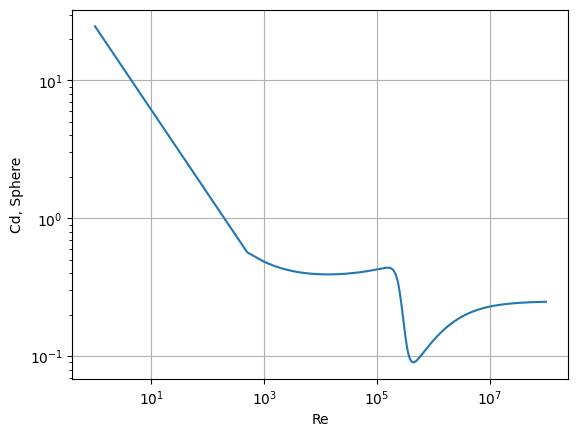

In [5]:
var = np.linspace(1,1E8,200000)
plt.plot(var,Cd(var))
plt.xscale("log");plt.yscale("log"); plt.xlabel('Re');plt.ylabel('Cd, Sphere'); plt.grid()
plt.show()

Assuming a spherical shape, the below function is the net force.

In [6]:
def netforce(v,rad,rho_fluid,rho_sphere,vis_fluid):
    Codrag = Cd(Re(v,rad,rho_fluid,vis_fluid))
    buoyancyandgravity = (rho_sphere-rho_fluid)/rho_sphere*gravity
    drag = 1/2*rho_fluid*Codrag/(rho_sphere*4/3*rad)*v**2 
    return buoyancyandgravity - drag

In [7]:
def inverse_netforce(v,rad,rho_fluid,rho_sphere,vis_fluid): #used to for integral of dv/(F/m) = dt
    return (1/netforce(v,rad,rho_fluid,rho_sphere,vis_fluid))

In [8]:
def func(v,rad,rho_sphere,rho_fluid,vis_fluid): #used to solve for the max (terminal) velocity
    Codrag = Cd(Re(v,rad,rho_fluid,vis_fluid))
    return (v-np.sqrt(8/3*gravity*rad/Codrag*(rho_sphere-rho_fluid)/rho_fluid))**2

In [9]:
def vmax(rad,rho_sphere,rho_fluid,vis_fluid):
    return fsolve(func,30,args=(rad,rho_sphere,rho_fluid,vis_fluid))

In [10]:
def time(v,rad,rho_fluid,rho_sphere,vis_fluid):
    return integrate.quad(inverse_netforce, 0, v,args=(rad,rho_fluid,rho_sphere,vis_fluid))

In [11]:
def dis2vmax(pos,vel,vmax):
    finterp = interpolate.interp1d(vel, pos)
    return finterp(vmax*0.98)

In [12]:
def ballistics(rad,rho_fluid,rho_sphere,vis_fluid): #returns the time, position, and velocity
    vmaxh = vmax(rad,rho_sphere,rho_fluid,vis_fluid)
    velArray = np.linspace(vmaxh*0.01,vmaxh*0.999,500)
    tt = [time(each,rad,rho_fluid,rho_sphere,vis_fluid)[0] for each in velArray]
    velArray = np.append(velArray,vmaxh);tt = np.append(tt,max(tt)*3/vmaxh*1.5)
    xpos = np.array([integrate.trapezoid(velArray[:i+1],x=tt[:i+1]) for i,each in enumerate(tt)])
    return tt,xpos,velArray

Specify variables

In [13]:
#property data
rad = 0.006/2 #m
rho_fluid = 1000 #kg/m3
rho_sphere = 7750 #kg/m3
vis_fluid = 1E-3 #Pa*s

In [14]:
vmaxh = vmax(rad,rho_sphere,rho_fluid,vis_fluid)

In [15]:
times,position,velocity = ballistics(rad,rho_fluid,rho_sphere,vis_fluid)

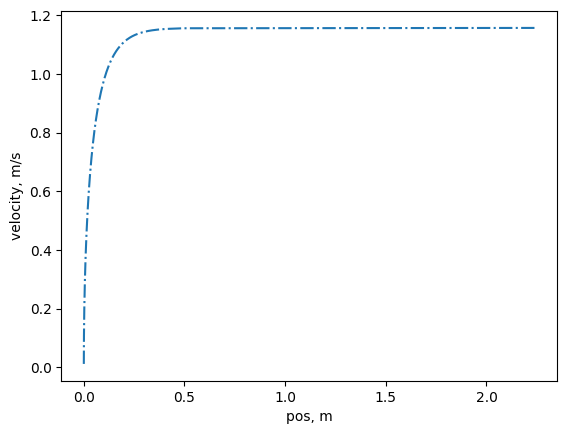

In [16]:
plt.plot(position,velocity,linestyle='-.')
plt.xlabel('pos, m');plt.ylabel('velocity, m/s')
#plt.ylim(0,0.25); plt.xlim(0,1)
plt.show()

The above plot shows how far it would require the ball to reach terminal velocity (velocity is constant).

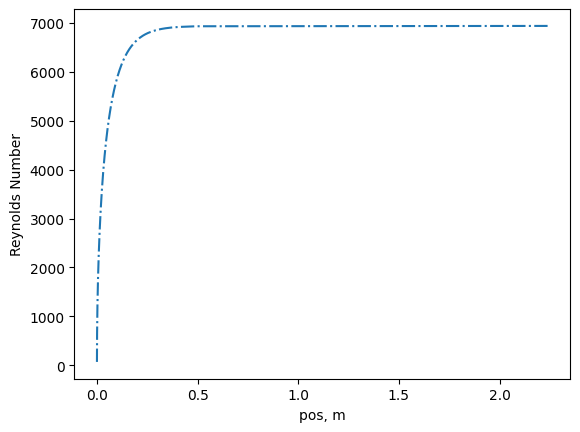

In [17]:
plt.plot(position,Re(velocity,rad,rho_fluid,vis_fluid),linestyle='-.')
plt.xlabel('pos, m');plt.ylabel('Reynolds Number')
#plt.ylim(0,0.25); plt.xlim(0,1)
plt.show()

The above plot shows the Reynolds number as a function of position.

In [18]:
#distance to terminal velocity (in)
dis2vmax(position,velocity,max(velocity))*100/2.54

10.11169009515604

In [19]:
#max velocity
vmaxh

array([1.15655456])